In [ ]:
!pip install transformers datasets tokenizers
#Install datasets
!wget http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip
!unzip -qq cornell_movie_dialogs_corpus.zip
!rm cornell_movie_dialogs_corpus.zip
!mkdir datasets
!mv cornell\ movie-dialogs\ corpus/movie_conversations.txt ./datasets
!mv cornell\ movie-dialogs\ corpus/movie_lines.txt ./datasets

--2024-07-14 15:15:02--  http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip
Resolving www.cs.cornell.edu (www.cs.cornell.edu)... 132.236.207.53
Connecting to www.cs.cornell.edu (www.cs.cornell.edu)|132.236.207.53|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9916637 (9.5M) [application/zip]
Saving to: ‘cornell_movie_dialogs_corpus.zip’

cornell_movie_dialo 100%[===================>]   9.46M  34.9MB/s    in 0.3s    

2024-07-14 15:15:03 (34.9 MB/s) - ‘cornell_movie_dialogs_corpus.zip’ saved [9916637/9916637]



In [ ]:
# Importing libraries

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

# Math
import math

# HuggingFace libraries
from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import WordPiece
from tokenizers.trainers import WordPieceTrainer
from tokenizers.pre_tokenizers import Whitespace
## importing the tokenizer and subword BPE trainer


# Pathlib
from pathlib import Path

# typing
from typing import Any

# Library for progress bars in loops
import tqdm

# Importing library of warnings
import warnings

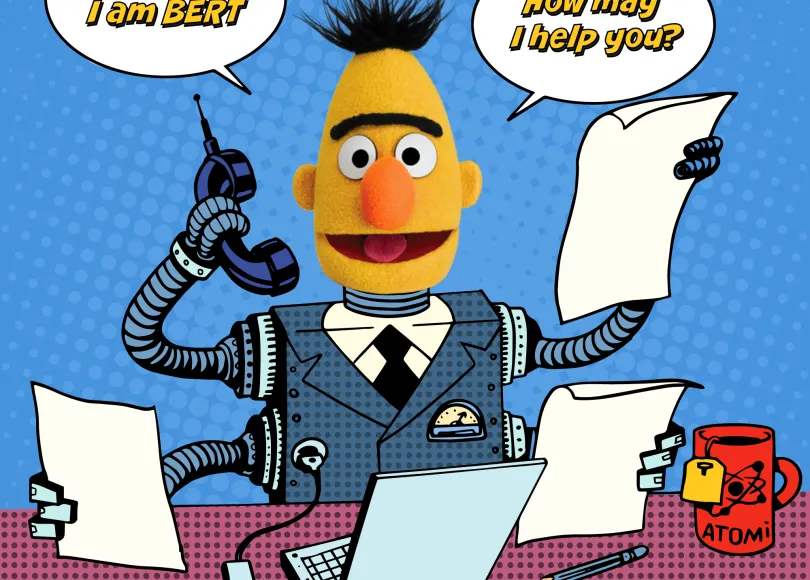

BERT which stands for Bidirectional Encoder Representation Transformer, a transformer based language model published by Google Research Team at 2018, is still gaining attention and being widely applied in Data Science Project today. This is due to the incredible model performance on multiple NLP tasks including question-answering, text tagging and sentence classification.

# **Embeddings**

The embedding in BERT comprises of three parts, mainly the token embeddings, segment embeddings and position embeddings.
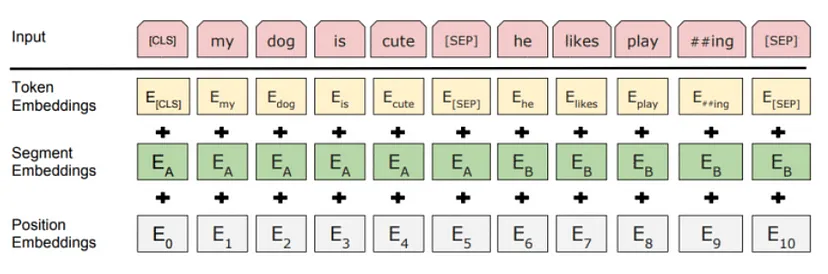

In NLP model, the order of the words and their position in a sentence matters and the meaning of the entire sentence can change if the words are re-ordered. As such, transformer model did a position embedding for each token in the input using the formula

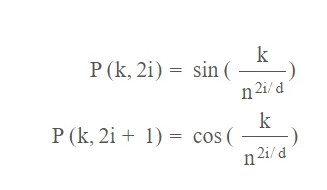

For all three different type of embeddings, they must be in the similar output size (768 in this case), so that all three of them can be summed together to be a single embedded output. You may notice thepadding_idx is specified as 0, this is to make pad token remains as 0 and not being updated during training.

In [ ]:
#Write code for Positional Encoding, donot add it with input embedding
class PositionalEncoding(torch.nn.Module):

    def __init__(self, d_model, max_len=128):
        super().__init__()

        self.dropout = nn.Dropout(p=dropout)

        # Creating a positional encoding matrix of shape (max_len, d_model) filled with zeros
        pe = torch.zeros(max_len, d_model)
        print("pe",pe)
        print("pe", pe.size())

        # Creating a tensor representing positions (0 to max_len - 1)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        print("pos",position)
        print("pos size",position.size())


        # Calculating the div_term using PyTorch
        div_term = torch.arange(0, d_model, 2, dtype=torch.float32) / d_model
        print("div_term size1", div_term.size())
        div_term = 1 / (10000 ** div_term)
        print("div_term",div_term)
        print("div_term size2", div_term.size())

        # Apply sine to even indices in pe
        pe[:, 0::2] = torch.sin(position * div_term.unsqueeze(0))
        print("pe Sin", pe)
        print("pe Sin", pe.size())

        # Apply cosine to odd indices in pe
        pe[:, 1::2] = torch.cos(position * div_term.unsqueeze(0))
        print("pe Cos", pe)
        print("pe Cos", pe.size())

        # Adding an extra dimension at the beginning of pe matrix for batch handling
        pe = pe.unsqueeze(0)
        print("pe size final", pe.size())
        # include the batch size
        self.pe = pe.unsqueeze(0)
        # self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe

In [ ]:
class BERTEmbedding(torch.nn.Module):
    """
    BERT Embedding which is consisted with under features
        1. TokenEmbedding : normal embedding matrix
        2. PositionalEmbedding : adding positional information using sin, cos
        2. SegmentEmbedding : adding sentence segment info, (sent_A:1, sent_B:2)
        sum of all these features are output of BERTEmbedding
    """

    def __init__(self, vocab_size, d_model, seq_len=64, dropout=0.1):
        """
        :param vocab_size: total vocab size
        :param d_model: embedding size of token embedding
        :param dropout: dropout rate
        The first parameter, 3, indicates the number of segments the model can differentiate between.
        In BERT, it's common to differentiate between two segments (Segment A and Segment B), plus a special
        segment for padding, which is often used when the model processes batches of sequences with varying lengths.
        padding_idx=0 specifies that the padding token should be ignored during the embedding lookup. This ensures that
        the padding token (often represented by index 0) does not contribute to the model's learning during training and inference.

        """

        super().__init__()
        self.d_model = d_model
        # (m, seq_len) --> (m, seq_len, d_model)
        # padding_idx is not updated during training, remains as fixed pad (0)
        self.token = nn.Embedding(vocab_size, d_model, padding_idx=0)
        self.segment = nn.Embedding(3,d_model, padding_idx=0)
        self.position = PositionalEncoding(d_model=d_model, max_len=seq_len)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, sequence, segment_label):
        x = self.token(sequence) + self.position(sequence) + self.segment(segment_label)
        return self.dropout(x)


In [ ]:
# Creating Layer Normalization

class LayerNormalization(nn.Module):

    def __init__(self, eps: float = 10**-6) -> None: # We define epsilon as 0.000001 to avoid division by zero
        super().__init__()
        self.eps = eps

        # We define alpha as a trainable parameter and initialize it with ones
        self.alpha = nn.Parameter(torch.ones(1)) # One-dimensional tensor that will be used to scale the input data

        # We define bias as a trainable parameter and initialize it with zeros
        self.bias = nn.Parameter(torch.zeros(1)) # One-dimensional tenso that will be added to the input data

    def forward(self, x):
        mean = x.mean(dim = -1, keepdim = True) # Computing the mean of the input data. Keeping the number of dimensions unchanged
        std = x.std(dim = -1, keepdim = True) # Computing the standard deviation of the input data. Keeping the number of dimensions unchanged

        # Returning the normalized input
        return self.alpha * (x-mean) / (std + self.eps) + self.bias

In [ ]:

class FeedForwardBlock(torch.nn.Module):
    "Implements FFN equation"

    def __init__(self, d_model, d_ff=2048, dropout=0.1):
        super(FeedForwardBlock, self).__init__()

        self.fc1 = torch.nn.Linear(d_model, d_ff)
        self.fc2 = torch.nn.Linear(d_ff, d_model)
        self.dropout = torch.nn.Dropout(dropout)
        self.activation = torch.nn.GELU()

    def forward(self, x):
        out = self.activation(self.fc1(x))
        out = self.fc2(self.dropout(out))
        return out


In [ ]:
# Building Residual Connection
class ResidualConnection(nn.Module):
    def __init__(self, dropout: float) -> None:
        super().__init__()
        self.dropout = nn.Dropout(dropout) # We use a dropout layer to prevent overfitting
        self.norm = LayerNormalization() # We use a normalization layer

    def forward(self, x, sublayer):
        # We normalize the input and add it to the original input 'x'. This creates the residual connection process.
        return x + self.dropout(sublayer(self.norm(x)))

In [ ]:
# Creating the Multi-Head Attention block
class MultiHeadAttentionBlock(nn.Module):

    def __init__(self, d_model: int, h: int, dropout: float) -> None: # h = number of heads
        super().__init__()
        self.d_model = d_model
        self.h = h

        # We ensure that the dimensions of the model is divisible by the number of heads
        assert d_model % h == 0, 'd_model is not divisible by h'

        # d_k is the dimension of each attention head's key, query, and value vectors
        self.d_k = d_model // h # d_k formula, like in the original "Attention Is All You Need" paper

        # Defining the weight matrices
#         self.w_q, self.w_k, self.w_v are nn.Linear layers that project the input d_model dimensional vectors to d_model dimensional vectors for
#         queries, keys, and values respectively. self.w_o is an nn.Linear layer that projects the concatenated output of the multi-head attention
#         mechanism back to d_model dimensional vectors.
        self.w_q = nn.Linear(d_model, d_model) # W_q
        self.w_k = nn.Linear(d_model, d_model) # W_k
        self.w_v = nn.Linear(d_model, d_model) # W_v
        self.w_o = nn.Linear(d_model, d_model) # W_o

        self.dropout = nn.Dropout(dropout) # Dropout layer to avoid overfitting


    @staticmethod
    def attention(query, key, value, mask, dropout: nn.Dropout):# mask => When we want certain words to NOT interact with others, we "hide" them

        d_k = query.shape[-1] # The last dimension of query, key, and value

        # We calculate the Attention(Q,K,V) as in the formula in the image above
        attention_scores = (query @ key.transpose(-2,-1)) / math.sqrt(d_k) # @ = Matrix multiplication sign in PyTorch
        print("attention score shape",attention_scores.shape)

        # Before applying the softmax, we apply the mask to hide some interactions between words
        if mask is not None: # If a mask IS defined...
            attention_scores.masked_fill_(mask == 0, -1e9) # Replace each value where mask is equal to 0 by -1e9
        attention_scores = attention_scores.softmax(dim = -1) # Applying softmax
        if dropout is not None: # If a dropout IS defined...
            attention_scores = dropout(attention_scores) # We apply dropout to prevent overfitting

        return (attention_scores @ value), attention_scores # Multiply the output matrix by the V matrix, as in the formula

    def forward(self, q, k, v, mask):

        query = self.w_q(q) # Q' matrix
        key = self.w_k(k) # K' matrix
        value = self.w_v(v) # V' matrix
        print("query shape", query.shape)
        print("key shape", key.shape)
        print("value shape", value.shape)


        # Splitting results into smaller matrices for the different heads
        # Splitting embeddings (third dimension) into h parts
        query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(1,2) # Transpose => bring the head to the second dimension
        key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1,2) # Transpose => bring the head to the second dimension
        value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(1,2) # Transpose => bring the head to the second dimension

        print("query shape after splitting into h heads", query.shape)
        print("key shape after splitting into h heads", key.shape)
        print("value shape after splitting into h heads", value.shape)

        # Obtaining the output and the attention scores
        x, self.attention_scores = MultiHeadAttentionBlock.attention(query, key, value, mask, self.dropout)

        # Obtaining the H matrix
        x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.h * self.d_k)

        return self.w_o(x) # Multiply the H matrix by the weight matrix W_o, resulting in the MH-A matrix

In [ ]:
# Building Encoder Block
class EncoderBlock(nn.Module):

    # This block takes in the MultiHeadAttentionBlock and FeedForwardBlock, as well as the dropout rate for the residual connections
    def __init__(self, self_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
        super().__init__()
        # Storing the self-attention block and feed-forward block
        self.self_attention_block = self_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(dropout) for _ in range(2)]) # 2 Residual Connections with dropout

    def forward(self, x, src_mask):
        # The source mask tensor, which is used in the self-attention mechanism to prevent attending to certain positions (like padding tokens).
        # Applying the first residual connection with the self-attention block
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, src_mask)) # Three 'x's corresponding to query, key, and value inputs plus source mask

        # Applying the second residual connection with the feed-forward block
        x = self.residual_connections[1](x, self.feed_forward_block)
        return x # Output tensor after applying self-attention and feed-forward layers with residual connections.


In [ ]:
# Building Encoder
# An Encoder can have several Encoder Blocks
class Encoder(nn.Module):

    # The Encoder takes in instances of 'EncoderBlock'
    def __init__(self, layers: nn.ModuleList) -> None:
        super().__init__()
        self.layers = layers # Storing the EncoderBlocks
        self.norm = LayerNormalization() # Layer for the normalization of the output of the encoder layers

    def forward(self, x, mask):
        # Iterating over each EncoderBlock stored in self.layers
        for layer in self.layers:
            x = layer(x, mask) # Applying each EncoderBlock to the input tensor 'x'
        return self.norm(x) # Normalizing output

The BERT class initializes the embedding layer for the input sequence, as well as multi layers of EncoderLayer blocks. The forward method of this class takes in the input sequence and a segment info tensor, applies attention masking to the input(for padded token), embeds the input sequence, and then passes it through the encoder blocks to obtain the output.

In [ ]:
class BERT(torch.nn.Module):
    """
    BERT model : Bidirectional Encoder Representations from Transformers.
    """

    def __init__(self, vocab_size, d_model=768, n_layers=12, heads=12, dropout=0.1):
        """
        :param vocab_size: vocab_size of total words
        :param hidden: BERT model hidden size
        :param n_layers: numbers of Transformer blocks(layers)
        :param attn_heads: number of attention heads
        :param dropout: dropout rate
        """

        super().__init__()
        self.d_model = d_model
        self.n_layers = n_layers
        self.heads = heads

        # Paper noted they used 4*hidden_size for ff_network_hidden_size
        self.feed_forward_hidden = d_model * 4

        # Embedding for BERT, sum of positional, segment, token embeddings
        self.embedding = BERTEmbedding(vocab_size=vocab_size, d_model=d_model)

        # Creating EncoderBlocks
        encoder_blocks = []
        for _ in range(n_layers):
            encoder_self_attention_block = MultiHeadAttentionBlock(d_model, heads, dropout)
            feed_forward_block = FeedForwardBlock(d_model, self.feed_forward_hidden, dropout)
            encoder_block = EncoderBlock(encoder_self_attention_block, feed_forward_block, dropout)
            encoder_blocks.append(encoder_block)

        # Creating the Encoder as a module list of encoder blocks
        self.encoder_blocks = nn.ModuleList(encoder_blocks)

    def forward(self, x, segment_info):
        # Attention masking for padded token
        # (batch_size, 1, seq_len, seq_len)
        mask = (x > 0).unsqueeze(1).repeat(1, x.size(1), 1).unsqueeze(1)

        # Embedding the indexed sequence to sequence of vectors
        x = self.embedding(x, segment_info)

        # Running over multiple transformer blocks
        for encoder in self.encoder_blocks:
            x = encoder.forward(x, mask)
        return x


The NextSentencePrediction class is a 2-class classification model that takes in the output of the BERT class and predicts whether the input sequence contains two consecutive sentences or not. The forward method applies applies linear transformation and log softmax function to obtain the predicted probabilities of the two classes.

In [ ]:
class NextSentencePrediction(torch.nn.Module):
    """
    2-class classification model : is_next, is_not_next
    """

    def __init__(self, hidden):
        """
        :param hidden: BERT model output size
        """
        super().__init__()
        self.linear = nn.Linear(hidden, 2)
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x):
        # use only the first token which is the [CLS]
        return self.softmax(self.linear(x[:, 0]))

The MaskedLanguageModel class is a multi-class classification model that takes in the output of the BERT class and predicts the original tokens for the masked input sequence. The forward method applies a linear transformation and log softmax function to obtain the predicted probabilities of each token in the vocabulary.

In [ ]:
class MaskedLanguageModel(torch.nn.Module):
    """
    predicting origin token from masked input sequence
    n-class classification problem, n-class = vocab_size
    """

    def __init__(self, hidden, vocab_size):
        """
        :param hidden: output size of BERT model
        :param vocab_size: total vocab size
        """
        super().__init__()
        self.linear = torch.nn.Linear(hidden, vocab_size)
        self.softmax = torch.nn.LogSoftmax(dim=-1)

    def forward(self, x):
        return self.softmax(self.linear(x))

The BERTLM class combines the BERT, NextSentencePrediction, and MaskedLanguageModel classes to create a complete BERT language model.

In [ ]:
class BERTLM(torch.nn.Module):
    """
    BERT Language Model
    Next Sentence Prediction Model + Masked Language Model
    """

    def __init__(self, bert: BERT, vocab_size):
        """
        :param bert: BERT model which should be trained
        :param vocab_size: total vocab size for masked_lm
        """

        super().__init__()
        self.bert = bert
        self.next_sentence = NextSentencePrediction(self.bert.d_model)
        self.mask_lm = MaskedLanguageModel(self.bert.d_model, vocab_size)

    def forward(self, x, segment_label):
        x = self.bert(x, segment_label)
        return self.next_sentence(x), self.mask_lm(x)


# **Tokenization**

In [ ]:
### data processing
MAX_LEN = 64

### loading all data into memory
corpus_movie_conv = './datasets/movie_conversations.txt'
corpus_movie_lines = './datasets/movie_lines.txt'
with open(corpus_movie_conv, 'r', encoding='iso-8859-1') as c:
    conv = c.readlines()
with open(corpus_movie_lines, 'r', encoding='iso-8859-1') as l:
    lines = l.readlines()

### splitting text using special lines
lines_dic = {}
for line in lines:
    objects = line.split(" +++$+++ ")
    lines_dic[objects[0]] = objects[-1]

### generate question answer pairs
pairs = []
for con in conv:
    ids = eval(con.split(" +++$+++ ")[-1])
    for i in range(len(ids)):
        qa_pairs = []

        if i == len(ids) - 1:
            break

        first = lines_dic[ids[i]].strip()
        second = lines_dic[ids[i+1]].strip()

        qa_pairs.append(' '.join(first.split()[:MAX_LEN]))
        qa_pairs.append(' '.join(second.split()[:MAX_LEN]))
        pairs.append(qa_pairs)

# sample
print(pairs[20])

["I really, really, really wanna go, but I can't. Not unless my sister goes.", "I'm workin' on it. But she doesn't seem to be goin' for him."]


In [ ]:
# WordPiece tokenizer
import os
### save data as txt file
os.mkdir('/content/data')
text_data = []
file_count = 0

for sample in tqdm.tqdm([x[0] for x in pairs]):
    text_data.append(sample)

    # once we hit the 10K mark, save to file
    if len(text_data) == 10000:
        with open(f'/content/data/text_{file_count}.txt', 'w', encoding='utf-8') as fp:
            fp.write('\n'.join(text_data))
        text_data = []
        file_count += 1

paths = [str(x) for x in Path('./data').glob('**/*.txt')]
print(len(paths))

100%|██████████| 221616/221616 [00:00<00:00, 1355227.62it/s]

22


In [ ]:
from collections import defaultdict
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

corpus = [
    "This is the Hugging Face Course.",
    "This chapter is about tokenization.",
    "This section shows several tokenizer algorithms.",
    "Hopefully, you will be able to understand how they are trained and generate tokens.",
]

### get the frequency of each word ###
word_freqs = defaultdict(int)
for text in corpus:
    words_with_offsets = tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)
    new_words = [word for word, offset in words_with_offsets]
    print(new_words)
    for word in new_words:
        word_freqs[word] += 1

print(f"\nFinal Word Frequency: {word_freqs}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

['This', 'is', 'the', 'Hugging', 'Face', 'Course', '.']
['This', 'chapter', 'is', 'about', 'tokenization', '.']
['This', 'section', 'shows', 'several', 'tokenizer', 'algorithms', '.']
['Hopefully', ',', 'you', 'will', 'be', 'able', 'to', 'understand', 'how', 'they', 'are', 'trained', 'and', 'generate', 'tokens', '.']

Final Word Frequency: defaultdict(<class 'int'>, {'This': 3, 'is': 2, 'the': 1, 'Hugging': 1, 'Face': 1, 'Course': 1, '.': 4, 'chapter': 1, 'about': 1, 'tokenization': 1, 'section': 1, 'shows': 1, 'several': 1, 'tokenizer': 1, 'algorithms': 1, 'Hopefully': 1, ',': 1, 'you': 1, 'will': 1, 'be': 1, 'able': 1, 'to': 1, 'understand': 1, 'how': 1, 'they': 1, 'are': 1, 'trained': 1, 'and': 1, 'generate': 1, 'tokens': 1})


In [ ]:
### split all word into alphabet ###
alphabet = []
for word in word_freqs.keys():
    if word[0] not in alphabet:
        alphabet.append(word[0])
    for letter in word[1:]:
        if f"##{letter}" not in alphabet:
            alphabet.append(f"##{letter}")

alphabet.sort()
print(f'All alphabets: {alphabet}')

### insert special token and subword ###
vocab = ["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"] + alphabet.copy()
splits = {word: [c if i == 0 else f"##{c}" for i, c in enumerate(word)] for word in word_freqs.keys()}
print(f'\nSplitted Words: {splits}')

All alphabets: ['##a', '##b', '##c', '##d', '##e', '##f', '##g', '##h', '##i', '##k', '##l', '##m', '##n', '##o', '##p', '##r', '##s', '##t', '##u', '##v', '##w', '##y', '##z', ',', '.', 'C', 'F', 'H', 'T', 'a', 'b', 'c', 'g', 'h', 'i', 's', 't', 'u', 'w', 'y']

Splitted Words: {'This': ['T', '##h', '##i', '##s'], 'is': ['i', '##s'], 'the': ['t', '##h', '##e'], 'Hugging': ['H', '##u', '##g', '##g', '##i', '##n', '##g'], 'Face': ['F', '##a', '##c', '##e'], 'Course': ['C', '##o', '##u', '##r', '##s', '##e'], '.': ['.'], 'chapter': ['c', '##h', '##a', '##p', '##t', '##e', '##r'], 'about': ['a', '##b', '##o', '##u', '##t'], 'tokenization': ['t', '##o', '##k', '##e', '##n', '##i', '##z', '##a', '##t', '##i', '##o', '##n'], 'section': ['s', '##e', '##c', '##t', '##i', '##o', '##n'], 'shows': ['s', '##h', '##o', '##w', '##s'], 'several': ['s', '##e', '##v', '##e', '##r', '##a', '##l'], 'tokenizer': ['t', '##o', '##k', '##e', '##n', '##i', '##z', '##e', '##r'], 'algorithms': ['a', '##l', '##g'

In [ ]:
 ### compute score for merging ###
def compute_pair_scores(splits):
    letter_freqs = defaultdict(int)
    pair_freqs = defaultdict(int)

    for word, freq in word_freqs.items():
        split = splits[word]
        if len(split) == 1:
            letter_freqs[split[0]] += freq
            continue
        for i in range(len(split) - 1):
            pair = (split[i], split[i + 1])
            letter_freqs[split[i]] += freq
            pair_freqs[pair] += freq
        letter_freqs[split[-1]] += freq

    scores = {
        pair: freq / (letter_freqs[pair[0]] * letter_freqs[pair[1]])
        for pair, freq in pair_freqs.items()
    }
    return scores

pair_scores = compute_pair_scores(splits)
print(f'Scores for each Pair: {pair_scores}')

Scores for each Pair: {('T', '##h'): 0.125, ('##h', '##i'): 0.03409090909090909, ('##i', '##s'): 0.02727272727272727, ('i', '##s'): 0.1, ('t', '##h'): 0.03571428571428571, ('##h', '##e'): 0.011904761904761904, ('H', '##u'): 0.1, ('##u', '##g'): 0.05, ('##g', '##g'): 0.0625, ('##g', '##i'): 0.022727272727272728, ('##i', '##n'): 0.01652892561983471, ('##n', '##g'): 0.022727272727272728, ('F', '##a'): 0.14285714285714285, ('##a', '##c'): 0.07142857142857142, ('##c', '##e'): 0.023809523809523808, ('C', '##o'): 0.07692307692307693, ('##o', '##u'): 0.046153846153846156, ('##u', '##r'): 0.022222222222222223, ('##r', '##s'): 0.022222222222222223, ('##s', '##e'): 0.004761904761904762, ('c', '##h'): 0.125, ('##h', '##a'): 0.017857142857142856, ('##a', '##p'): 0.07142857142857142, ('##p', '##t'): 0.07142857142857142, ('##t', '##e'): 0.013605442176870748, ('##e', '##r'): 0.026455026455026454, ('a', '##b'): 0.2, ('##b', '##o'): 0.038461538461538464, ('##u', '##t'): 0.02857142857142857, ('t', '##o')

In [ ]:
### finding pair with best score ###
best_pair = ""
max_score = None
for pair, score in pair_scores.items():
    if max_score is None or max_score < score:
        best_pair = pair
        max_score = score

print(best_pair, max_score)
vocab.append("ab")

### merge pair ###
def merge_pair(a, b, splits):
    for word in word_freqs:
        split = splits[word]
        if len(split) == 1:
            continue
        i = 0
        while i < len(split) - 1:
            if split[i] == a and split[i + 1] == b:
                merge = a + b[2:] if b.startswith("##") else a + b
                split = split[:i] + [merge] + split[i + 2 :]
            else:
                i += 1
        splits[word] = split
    return splits

splits = merge_pair("a", "##b", splits)
print(splits["about"])

('a', '##b') 0.2
['ab', '##o', '##u', '##t']


In [ ]:
### keep looping to merge more pair
vocab_size = 70
while len(vocab) < vocab_size:
    scores = compute_pair_scores(splits)
    best_pair, max_score = "", None
    for pair, score in scores.items():
        if max_score is None or max_score < score:
            best_pair = pair
            max_score = score
    splits = merge_pair(*best_pair, splits)
    new_token = (
        best_pair[0] + best_pair[1][2:]
        if best_pair[1].startswith("##")
        else best_pair[0] + best_pair[1]
    )
    vocab.append(new_token)

print(f'Final Vocab: {vocab}')

Final Vocab: ['[PAD]', '[UNK]', '[CLS]', '[SEP]', '[MASK]', '##a', '##b', '##c', '##d', '##e', '##f', '##g', '##h', '##i', '##k', '##l', '##m', '##n', '##o', '##p', '##r', '##s', '##t', '##u', '##v', '##w', '##y', '##z', ',', '.', 'C', 'F', 'H', 'T', 'a', 'b', 'c', 'g', 'h', 'i', 's', 't', 'u', 'w', 'y', 'ab', '##fu', 'Fa', 'Fac', '##ct', '##ful', '##full', '##fully', 'Th', 'ch', '##hm', 'cha', 'chap', 'chapt', '##thm', 'Hu', 'Hug', 'Hugg', 'sh', 'th', 'is', '##thms', '##za', '##zat', '##ut']


In [ ]:
### ro encode a word ###
def encode_word(word):
    tokens = []
    while len(word) > 0:
        i = len(word)
        while i > 0 and word[:i] not in vocab:
            i -= 1
        if i == 0:
            return ["[UNK]"]
        tokens.append(word[:i])
        word = word[i:]
        if len(word) > 0:
            word = f"##{word}"
    return tokens

print(encode_word("Hugging"))
print(encode_word("HOgging"))

['Hugg', '##i', '##n', '##g']
['[UNK]']


In [ ]:
### training own tokenizer
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer
tokenizer = BertWordPieceTokenizer(
    clean_text=True,
    handle_chinese_chars=False,
    strip_accents=False,
    lowercase=True
)

tokenizer.train(
    files=paths,
    vocab_size=30_000,
    min_frequency=5,
    limit_alphabet=1000,
    wordpieces_prefix='##',
    special_tokens=['[PAD]', '[CLS]', '[SEP]', '[MASK]', '[UNK]']
    )

#os.mkdir('./bert-it-1')
tokenizer.save_model('./bert-it-1', 'bert-it')
tokenizer = BertTokenizer.from_pretrained('./bert-it-1/bert-it-vocab.txt', local_files_only=True)
token_ids = tokenizer('I like surfboarding!')['input_ids']
print(token_ids)
print(tokenizer.convert_ids_to_tokens(token_ids))

[1, 48, 250, 4033, 3588, 154, 5, 2]
['[CLS]', 'i', 'like', 'surf', '##board', '##ing', '!', '[SEP]']


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2004: FutureWarning: Calling BertTokenizer.from_pretrained() with the path to a single file or url is deprecated and won't be possible anymore in v5. Use a model identifier or the path to a directory instead.
  warnings.warn(


**Walkthrough of random function**

["I", "love", "machine", "learning"]

Assume random probabilities for each token: [0.12, 0.50, 0.10, 0.85].


Token "I":

prob = 0.12 (less than 0.15).

Scaled prob = 0.12 / 0.15 = 0.8.

80% chance to mask: replace with [MASK].

Token "love":

prob = 0.50 (greater than 0.15).

Keep unchanged.

Token "machine":

prob = 0.10 (less than 0.15).

Scaled prob = 0.10 / 0.15 = 0.67.

80% chance to mask: replace with [MASK].

Token "learning":

prob = 0.85 (greater than 0.15).

Keep unchanged.

# **Training**

In [ ]:
# The BERTDataset class is a custom dataset implementation for preparing input data for BERT training.
# Here's a detailed explanation of its components and methods:
import random
import itertools
#Inherits from torch.utils.data.Dataset, making it compatible with PyTorch's data loading utilities.
class BERTDataset(Dataset):
    def __init__(self, data_pair, tokenizer, seq_len=64):
      #datapair:# A list of sentence pairs.
        self.tokenizer = tokenizer #A tokenizer object for converting sentences into token IDs.
        self.seq_len = seq_len  #The maximum sequence length for the input.
        self.corpus_lines = len(data_pair) # The total number of sentence pairs.
        self.lines = data_pair #Stores the sentence pairs.

    def __len__(self):
        return self.corpus_lines

    def __getitem__(self, item):

        # Step 1: get random sentence pair, either negative or positive (saved as is_next_label)
        t1, t2, is_next_label = self.get_sent(item)

        # Step 2: replace random words in sentence with mask / random words
        t1_random, t1_label = self.random_word(t1)
        t2_random, t2_label = self.random_word(t2)

        # Step 3: Adding CLS and SEP tokens to the start and end of sentences
        # Adding PAD token for labels
        t1 = [self.tokenizer.vocab['[CLS]']] + t1_random + [self.tokenizer.vocab['[SEP]']]
        t2 = t2_random + [self.tokenizer.vocab['[SEP]']]
        t1_label = [self.tokenizer.vocab['[PAD]']] + t1_label + [self.tokenizer.vocab['[PAD]']]
        t2_label = t2_label + [self.tokenizer.vocab['[PAD]']]

        # Step 4: combine sentence 1 and 2 as one input
        # adding PAD tokens to make the sentence same length as seq_len

        # Example
        # Let's assume the following:

        # self.seq_len is 10.
        # t1 is [101, 102, 103] (with token IDs corresponding to the first sentence).
        # t2 is [201, 202] (with token IDs corresponding to the second sentence).
        # t1_label is [0, 0, 0] (indicating no masked tokens in the first sentence).
        # t2_label is [0, 0] (indicating no masked tokens in the second sentence).
        # [PAD] has a token ID of 0.

        segment_label = ([1 for _ in range(len(t1))] + [2 for _ in range(len(t2))])[:self.seq_len] ## segment_label = [1, 1, 1, 2, 2]
        bert_input = (t1 + t2)[:self.seq_len] ## bert_input = [101, 102, 103, 201, 202]
        bert_label = (t1_label + t2_label)[:self.seq_len] # bert_label = [0, 0, 0, 0, 0]
        padding = [self.tokenizer.vocab['[PAD]'] for _ in range(self.seq_len - len(bert_input))] ## padding_length = 10 - 5 = 5, # padding = [0, 0, 0, 0, 0]
        bert_input.extend(padding), bert_label.extend(padding), segment_label.extend(padding)

      #   bert_input.extend(padding)
      #  # bert_input = [101, 102, 103, 201, 202, 0, 0, 0, 0, 0]

      #  bert_label.extend(padding)
      # # bert_label = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

      # segment_label.extend(padding)
      # # segment_label = [1, 1, 1, 2, 2, 0, 0, 0, 0, 0]

        output = {"bert_input": bert_input,
                  "bert_label": bert_label,
                  "segment_label": segment_label,
                  "is_next": is_next_label}

        return {key: torch.tensor(value) for key, value in output.items()}

    def random_word(self, sentence):
        tokens = sentence.split()
        output_label = []
        output = []

        # 15% of the tokens would be replaced
        for i, token in enumerate(tokens):
            prob = random.random()

            # remove cls and sep token
            token_id = self.tokenizer(token)['input_ids'][1:-1]

            # 15% chance of altering token
            if prob < 0.15:
                prob /= 0.15

                # 80% chance change token to mask token
                if prob < 0.8:
                    for i in range(len(token_id)):
                        output.append(self.tokenizer.vocab['[MASK]'])

                # 10% chance change token to random token
                elif prob < 0.9:
                    for i in range(len(token_id)):
                        output.append(random.randrange(len(self.tokenizer.vocab)))

                # 10% chance change token to current token
                else:
                    output.append(token_id)

                output_label.append(token_id)

            else:
                output.append(token_id)
                for i in range(len(token_id)):
                    output_label.append(0)

        # flattening
        output = list(itertools.chain(*[[x] if not isinstance(x, list) else x for x in output]))
        output_label = list(itertools.chain(*[[x] if not isinstance(x, list) else x for x in output_label]))
        assert len(output) == len(output_label)
        return output, output_label

    def get_sent(self, index):
        '''return random sentence pair'''
        t1, t2 = self.get_corpus_line(index)

        # negative or positive pair, for next sentence prediction
        if random.random() > 0.5:
            return t1, t2, 1
        else:
            return t1, self.get_random_line(), 0

    def get_corpus_line(self, item):
        '''return sentence pair'''
        return self.lines[item][0], self.lines[item][1]

    def get_random_line(self):
        '''return random single sentence'''
        return self.lines[random.randrange(len(self.lines))][1]

In [ ]:
### optimizer
import numpy as np
class ScheduledOptim():
    '''A simple wrapper class for learning rate scheduling'''

    def __init__(self, optimizer, d_model, n_warmup_steps):
        self._optimizer = optimizer
        self.n_warmup_steps = n_warmup_steps
        self.n_current_steps = 0
        self.init_lr = np.power(d_model, -0.5)

    def step_and_update_lr(self):
        "Step with the inner optimizer"
        self._update_learning_rate()
        self._optimizer.step()

    def zero_grad(self):
        "Zero out the gradients by the inner optimizer"
        self._optimizer.zero_grad()

    def _get_lr_scale(self):
        return np.min([
            np.power(self.n_current_steps, -0.5),
            np.power(self.n_warmup_steps, -1.5) * self.n_current_steps])

    def _update_learning_rate(self):
        ''' Learning rate scheduling per step '''

        self.n_current_steps += 1
        lr = self.init_lr * self._get_lr_scale()

        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr

In [ ]:
### trainer
from torch.optim import Adam
class BERTTrainer:
    def __init__(
        self,
        model,
        train_dataloader,
        test_dataloader=None,
        lr= 1e-4,
        weight_decay=0.01,
        betas=(0.9, 0.999),
        warmup_steps=10000,
        log_freq=10,
        device='cuda'
        ):

        self.device = device
        self.model = model
        self.train_data = train_dataloader
        self.test_data = test_dataloader

        # Setting the Adam optimizer with hyper-param
        self.optim = Adam(self.model.parameters(), lr=lr, betas=betas, weight_decay=weight_decay)
        self.optim_schedule = ScheduledOptim(
            self.optim, self.model.bert.d_model, n_warmup_steps=warmup_steps
            )

        # Using Negative Log Likelihood Loss function for predicting the masked_token
        self.criterion = torch.nn.NLLLoss(ignore_index=0)
        self.log_freq = log_freq
        print("Total Parameters:", sum([p.nelement() for p in self.model.parameters()]))

    def train(self, epoch):
        self.iteration(epoch, self.train_data)

    def test(self, epoch):
        self.iteration(epoch, self.test_data, train=False)

    def iteration(self, epoch, data_loader, train=True):

        avg_loss = 0.0
        total_correct = 0
        total_element = 0

        mode = "train" if train else "test"

        # progress bar
        data_iter = tqdm.tqdm(
            enumerate(data_loader),
            desc="EP_%s:%d" % (mode, epoch),
            total=len(data_loader),
            bar_format="{l_bar}{r_bar}"
        )

        for i, data in data_iter:

            # 0. batch_data will be sent into the device(GPU or cpu)
            data = {key: value.to(self.device) for key, value in data.items()}

            # 1. forward the next_sentence_prediction and masked_lm model
            next_sent_output, mask_lm_output = self.model.forward(data["bert_input"], data["segment_label"])

            # 2-1. NLL(negative log likelihood) loss of is_next classification result
            next_loss = self.criterion(next_sent_output, data["is_next"])

            # 2-2. NLLLoss of predicting masked token word
            # transpose to (m, vocab_size, seq_len) vs (m, seq_len)
            # criterion(mask_lm_output.view(-1, mask_lm_output.size(-1)), data["bert_label"].view(-1))
            mask_loss = self.criterion(mask_lm_output.transpose(1, 2), data["bert_label"])

            # 2-3. Adding next_loss and mask_loss : 3.4 Pre-training Procedure
            loss = next_loss + mask_loss

            # 3. backward and optimization only in train
            if train:
                self.optim_schedule.zero_grad()
                loss.backward()
                self.optim_schedule.step_and_update_lr()

            # next sentence prediction accuracy
            correct = next_sent_output.argmax(dim=-1).eq(data["is_next"]).sum().item()
            avg_loss += loss.item()
            total_correct += correct
            total_element += data["is_next"].nelement()

            post_fix = {
                "epoch": epoch,
                "iter": i,
                "avg_loss": avg_loss / (i + 1),
                "avg_acc": total_correct / total_element * 100,
                "loss": loss.item()
            }

            if i % self.log_freq == 0:
                data_iter.write(str(post_fix))
        print(
            f"EP{epoch}, {mode}: \
            avg_loss={avg_loss / len(data_iter)}, \
            total_acc={total_correct * 100.0 / total_element}"
        )

### test
train_data = BERTDataset(pairs, seq_len=MAX_LEN, tokenizer=tokenizer)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, pin_memory=True)
bert_model = BERT(len(tokenizer.vocab))
bert_lm = BERTLM(bert_model, len(tokenizer.vocab))
bert_trainer = BERTTrainer(bert_lm, train_loader, device='cpu')
epochs = 2

for epoch in range(epochs):
    bert_trainer.train(epoch)

Total Parameters: 117544410


EP_train:0:   0%|| 0/6926 [00:00<?, ?it/s]

query shape torch.Size([32, 64, 768])
key shape torch.Size([32, 64, 768])
value shape torch.Size([32, 64, 768])
query shape after splitting into h heads torch.Size([32, 12, 64, 64])
key shape after splitting into h heads torch.Size([32, 12, 64, 64])
value shape after splitting into h heads torch.Size([32, 12, 64, 64])
attention score shape torch.Size([32, 12, 64, 64])
query shape torch.Size([32, 64, 768])
key shape torch.Size([32, 64, 768])
value shape torch.Size([32, 64, 768])
query shape after splitting into h heads torch.Size([32, 12, 64, 64])
key shape after splitting into h heads torch.Size([32, 12, 64, 64])
value shape after splitting into h heads torch.Size([32, 12, 64, 64])
attention score shape torch.Size([32, 12, 64, 64])
query shape torch.Size([32, 64, 768])
key shape torch.Size([32, 64, 768])
value shape torch.Size([32, 64, 768])
query shape after splitting into h heads torch.Size([32, 12, 64, 64])
key shape after splitting into h heads torch.Size([32, 12, 64, 64])
value sh

EP_train:0:   0%|| 1/6926 [00:41<79:38:40, 41.40s/it]

{'epoch': 0, 'iter': 0, 'avg_loss': 13.233497619628906, 'avg_acc': 43.75, 'loss': 13.233497619628906}
query shape torch.Size([32, 64, 768])
key shape torch.Size([32, 64, 768])
value shape torch.Size([32, 64, 768])
query shape after splitting into h heads torch.Size([32, 12, 64, 64])
key shape after splitting into h heads torch.Size([32, 12, 64, 64])
value shape after splitting into h heads torch.Size([32, 12, 64, 64])
attention score shape torch.Size([32, 12, 64, 64])
query shape torch.Size([32, 64, 768])
key shape torch.Size([32, 64, 768])
value shape torch.Size([32, 64, 768])
query shape after splitting into h heads torch.Size([32, 12, 64, 64])
key shape after splitting into h heads torch.Size([32, 12, 64, 64])
value shape after splitting into h heads torch.Size([32, 12, 64, 64])
attention score shape torch.Size([32, 12, 64, 64])
query shape torch.Size([32, 64, 768])
key shape torch.Size([32, 64, 768])
value shape torch.Size([32, 64, 768])
query shape after splitting into h heads tor

EP_train:0:   0%|| 2/6926 [01:11<67:05:22, 34.88s/it]

query shape torch.Size([32, 64, 768])
key shape torch.Size([32, 64, 768])
value shape torch.Size([32, 64, 768])
query shape after splitting into h heads torch.Size([32, 12, 64, 64])
key shape after splitting into h heads torch.Size([32, 12, 64, 64])
value shape after splitting into h heads torch.Size([32, 12, 64, 64])
attention score shape torch.Size([32, 12, 64, 64])
query shape torch.Size([32, 64, 768])
key shape torch.Size([32, 64, 768])
value shape torch.Size([32, 64, 768])
query shape after splitting into h heads torch.Size([32, 12, 64, 64])
key shape after splitting into h heads torch.Size([32, 12, 64, 64])
value shape after splitting into h heads torch.Size([32, 12, 64, 64])
attention score shape torch.Size([32, 12, 64, 64])
query shape torch.Size([32, 64, 768])
key shape torch.Size([32, 64, 768])
value shape torch.Size([32, 64, 768])
query shape after splitting into h heads torch.Size([32, 12, 64, 64])
key shape after splitting into h heads torch.Size([32, 12, 64, 64])
value sh

EP_train:0:   0%|| 3/6926 [01:38<60:05:20, 31.25s/it]

query shape torch.Size([32, 64, 768])
key shape torch.Size([32, 64, 768])
value shape torch.Size([32, 64, 768])
query shape after splitting into h heads torch.Size([32, 12, 64, 64])
key shape after splitting into h heads torch.Size([32, 12, 64, 64])
value shape after splitting into h heads torch.Size([32, 12, 64, 64])
attention score shape torch.Size([32, 12, 64, 64])
query shape torch.Size([32, 64, 768])
key shape torch.Size([32, 64, 768])
value shape torch.Size([32, 64, 768])
query shape after splitting into h heads torch.Size([32, 12, 64, 64])
key shape after splitting into h heads torch.Size([32, 12, 64, 64])
value shape after splitting into h heads torch.Size([32, 12, 64, 64])
attention score shape torch.Size([32, 12, 64, 64])
query shape torch.Size([32, 64, 768])
key shape torch.Size([32, 64, 768])
value shape torch.Size([32, 64, 768])
query shape after splitting into h heads torch.Size([32, 12, 64, 64])
key shape after splitting into h heads torch.Size([32, 12, 64, 64])
value sh

EP_train:0:   0%|| 4/6926 [02:12<62:08:42, 32.32s/it]

query shape torch.Size([32, 64, 768])
key shape torch.Size([32, 64, 768])
value shape torch.Size([32, 64, 768])
query shape after splitting into h heads torch.Size([32, 12, 64, 64])
key shape after splitting into h heads torch.Size([32, 12, 64, 64])
value shape after splitting into h heads torch.Size([32, 12, 64, 64])
attention score shape torch.Size([32, 12, 64, 64])
query shape torch.Size([32, 64, 768])
key shape torch.Size([32, 64, 768])
value shape torch.Size([32, 64, 768])
query shape after splitting into h heads torch.Size([32, 12, 64, 64])
key shape after splitting into h heads torch.Size([32, 12, 64, 64])
value shape after splitting into h heads torch.Size([32, 12, 64, 64])
attention score shape torch.Size([32, 12, 64, 64])
query shape torch.Size([32, 64, 768])
key shape torch.Size([32, 64, 768])
value shape torch.Size([32, 64, 768])
query shape after splitting into h heads torch.Size([32, 12, 64, 64])
key shape after splitting into h heads torch.Size([32, 12, 64, 64])
value sh

EP_train:0:   0%|| 5/6926 [02:41<59:58:59, 31.20s/it]

query shape torch.Size([32, 64, 768])
key shape torch.Size([32, 64, 768])
value shape torch.Size([32, 64, 768])
query shape after splitting into h heads torch.Size([32, 12, 64, 64])
key shape after splitting into h heads torch.Size([32, 12, 64, 64])
value shape after splitting into h heads torch.Size([32, 12, 64, 64])
attention score shape torch.Size([32, 12, 64, 64])
query shape torch.Size([32, 64, 768])
key shape torch.Size([32, 64, 768])
value shape torch.Size([32, 64, 768])
query shape after splitting into h heads torch.Size([32, 12, 64, 64])
key shape after splitting into h heads torch.Size([32, 12, 64, 64])
value shape after splitting into h heads torch.Size([32, 12, 64, 64])
attention score shape torch.Size([32, 12, 64, 64])
query shape torch.Size([32, 64, 768])
key shape torch.Size([32, 64, 768])
value shape torch.Size([32, 64, 768])
query shape after splitting into h heads torch.Size([32, 12, 64, 64])
key shape after splitting into h heads torch.Size([32, 12, 64, 64])
value sh

EP_train:0:   0%|| 6/6926 [03:16<62:25:30, 32.48s/it]

query shape torch.Size([32, 64, 768])
key shape torch.Size([32, 64, 768])
value shape torch.Size([32, 64, 768])
query shape after splitting into h heads torch.Size([32, 12, 64, 64])
key shape after splitting into h heads torch.Size([32, 12, 64, 64])
value shape after splitting into h heads torch.Size([32, 12, 64, 64])
attention score shape torch.Size([32, 12, 64, 64])
query shape torch.Size([32, 64, 768])
key shape torch.Size([32, 64, 768])
value shape torch.Size([32, 64, 768])
query shape after splitting into h heads torch.Size([32, 12, 64, 64])
key shape after splitting into h heads torch.Size([32, 12, 64, 64])
value shape after splitting into h heads torch.Size([32, 12, 64, 64])
attention score shape torch.Size([32, 12, 64, 64])
query shape torch.Size([32, 64, 768])
key shape torch.Size([32, 64, 768])
value shape torch.Size([32, 64, 768])
query shape after splitting into h heads torch.Size([32, 12, 64, 64])
key shape after splitting into h heads torch.Size([32, 12, 64, 64])
value sh

EP_train:0:   0%|| 6/6926 [03:43<71:27:07, 37.17s/it]


KeyboardInterrupt: 

Needless to say, it’s impractical to train the huge BERT model from scratch unless you have extensive resources and compute power. A more reproducible way is by downloading the pretrained model and fine tune it on a downstream task. Going through every single line of codes to build a model from scratch is undeniably brain-drowning, yet, it’s the most intensive way to understand the model thoroughly. It’s definitely worth of our time to do that for the first time as such experience offers us a totally different perspective in understanding the model.

# References

https://medium.com/data-and-beyond/complete-guide-to-building-bert-model-from-sratch-3e6562228891

https://medium.com/@samia.khalid/bert-explained-a-complete-guide-with-theory-and-tutorial-3ac9ebc8fa7c

https://youtu.be/90mGPxR2GgY?si=S335QtYltoRKgN-5